##Tasks Done:
####Gokul Krishna


1.   Own solution for  Preprocessing
2.   Data cleaning, reading with correct format
3.   Visualising
4.   BiLstm modelling, evaluation, Fine-Tuning of two rounds




In [2]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
file_path = '/content/drive/My Drive/dataset/Sentiment_Data/Sentiment_Data.csv'

In [4]:
import os

if os.path.exists(file_path):
  print("file exists")
else:
  print("file does not exists")

file exists


In [5]:
import pandas as pd


In [6]:
df = pd.read_csv(file_path)
df.head(5)

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 211300-211301: invalid continuation byte

##It says file can't be decoded with the utf-8 codec Let us check the Unicode Format of the file

In [7]:
import chardet

file_path = '/content/drive/MyDrive/dataset/Sentiment_Data/Sentiment_Data.csv'

# Read a sample of the file in binary mode
with open(file_path, 'rb') as f:
    result = chardet.detect(f.read(100000))  # Reads first 100 KB of the file

# Print detected encoding
print("Detected encoding:", result['encoding'])


Detected encoding: MacRoman


### Now I am converting the file to the UTF-8 (padas' default encoding format) for better compatability

In [8]:
# Step 1: Read the original file as raw bytes using MacRoman encoding
with open('/content/drive/MyDrive/dataset/Sentiment_Data/Sentiment_Data.csv', 'rb') as f:
    raw_data = f.read()

# Step 2: Decode the bytes using utf8 encoding
decoded_data = raw_data.decode('utf-8', errors='ignore')

# Step 3: Save the decoded content as a new UTF-8 encoded file
utf8_path = '/content/drive/MyDrive/dataset/Sentiment_Data/Sentiment_Data_utf8.csv'
with open(utf8_path, 'w', encoding='utf-8') as f:
    f.write(decoded_data)

# Step 4: Load the UTF-8 file into a DataFrame
df = pd.read_csv(utf8_path, encoding='utf-8')

print("File saved in UTF-8 format at:", utf8_path)


File saved in UTF-8 format at: /content/drive/MyDrive/dataset/Sentiment_Data/Sentiment_Data_utf8.csv


##Reading the saved UTF-8 File

In [9]:
df_UTF = pd.read_csv(utf8_path)
df.head(5)

,Tweet,Sentiment
0,@_angelica_toy Happy Anniversary!!!....The Day...,Mild_Pos
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,Mild_Pos
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,Mild_Pos
3,@NChartierET Happy Anniversary!!!....The Day t...,Mild_Pos
4,@tabithapeters05 Happy Anniversary!!!....The D...,Mild_Pos


In [11]:
number_of_words=len(df.Tweet.unique())
print("Number of unique words in the tweet: ", number_of_words)

Number of unique words in the tweet:  451280


In [12]:
from collections import Counter
import re

# Combine all tweets into one string
all_text = " ".join(df['Tweet'].astype(str))

# Tokenize words — simple way using regex to split on non-word characters
words = re.findall(r'\b\w+\b', all_text.lower())  # lowercase to treat 'The' and 'the' as same

# Count word frequencies
word_counts = Counter(words)
print("total number of words : ",sum(word_counts.values()),"\n\n")
# Get the 20 most common words
top_20 = word_counts.most_common(20)

# Print the results
for word, count in top_20:
    print(f"{word}: {count}")


total number of words :  11774376 


the: 513232
freedom: 384551
convoy: 372405
t: 298687
to: 257765
co: 243036
https: 241352
of: 186826
and: 167120
a: 156799
in: 138468
is: 119851
for: 104722
s: 98675
freedomconvoy: 94086
you: 91554
it: 82275
i: 82205
that: 81592
on: 70945


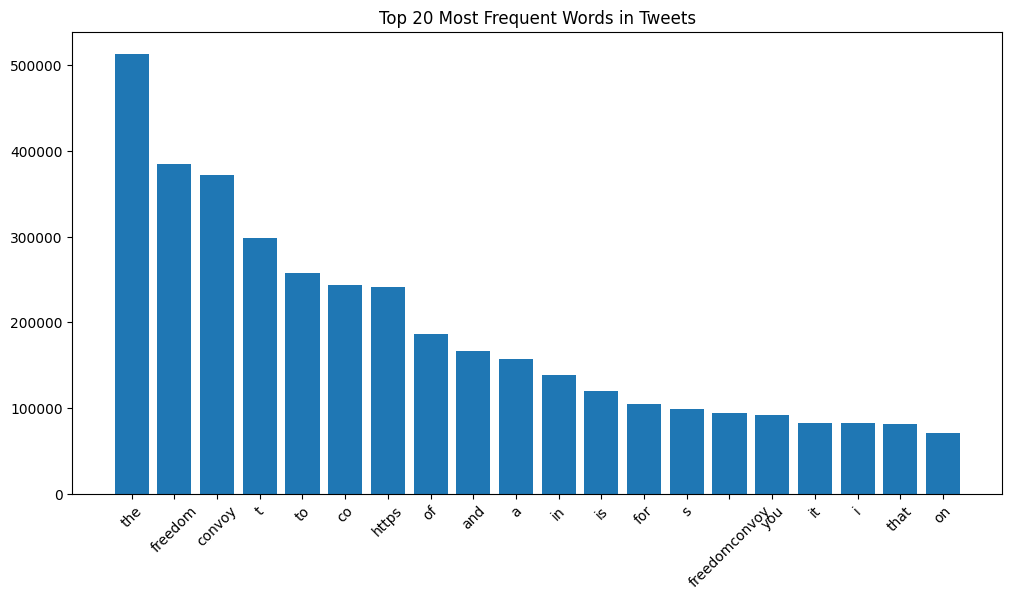

In [13]:
import matplotlib.pyplot as plt

words, counts = zip(*top_20)

plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words in Tweets')
plt.show()


## we can count check and count for the labels and check for the imbalance

In [14]:
df.Sentiment.unique()

array(['Mild_Pos', 'Strong_Pos', 'Neutral', 'Strong_Neg', 'Mild_Neg'],
      dtype=object)

Sentiment
Strong_Pos    233700
Neutral        77016
Mild_Pos       64004
Strong_Neg     42556
Mild_Neg       34056
Name: count, dtype: int64


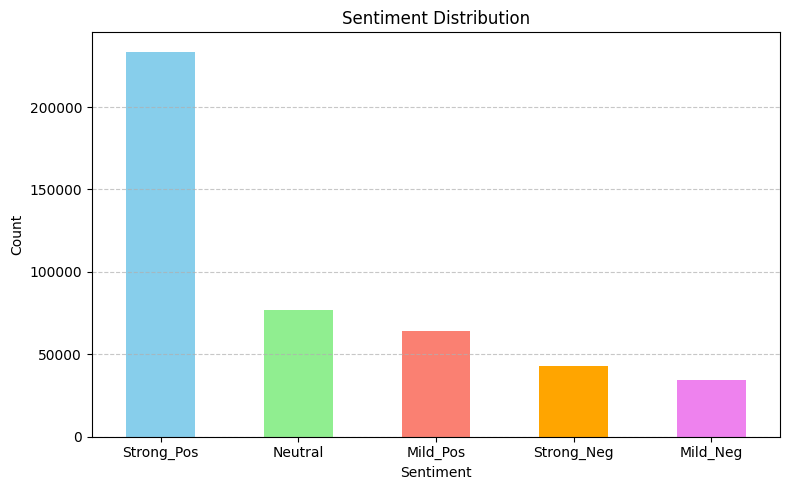

In [15]:
import matplotlib.pyplot as plt

# Get counts of unique sentiment labels
sentiment_counts = df['Sentiment'].value_counts()

# Display the counts
print(sentiment_counts)

# Plotting
plt.figure(figsize=(8, 5))
colors = ['skyblue', 'lightgreen', 'salmon', 'orange', 'violet']  # extend as needed

# Bar plot
sentiment_counts.plot(kind='bar', color=colors[:len(sentiment_counts)])

plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


 Huge imbalance exists for the positive words

## preprocessing the the Sentiment column

###Function for preprocessing:

1.Converts text to lowercase

2.Removes URLs

3.Removes Twitter mentions (@user)

4.Removes hashtag symbols (#) but keeps the word

5.Removes punctuation

6.Removes numbers

7.Splits text into individual words (tokenization) with SLANG WORDS removal

8.Removes stopwords (like "the", "is", "and")

9.Removes very short words (length ≤ 1)

10.Lemmatizes each word to its base form (e.g., "running" → "run")

11.Joins the cleaned words back into a single string

In [16]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')  # also needed for lemmatization
nltk.download('omw-1.4')  # optional but helps lemmatizer with more words


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [17]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()


# Define slang dictionary
slang_dict = {
    "brb": "be right back",
    "lol": "laugh out loud",
    "idk": "I don’t know",
    "imo": "in my opinion",
    "btw": "by the way"
}

# Final unified preprocessing function
def preprocess_text_with_lemmatization(text):
    # 1. Convert any input to string
    text = str(text)

    # 2. Convert text to lowercase
    text = text.lower()

    # 3. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # 4. Remove mentions, hashtags, and special characters (keep only letters and spaces)
    text = re.sub(r"@\w+|#\w+|[^a-z\s]", "", text)

    # 5. Expand slangs
    words = text.split()
    words = [slang_dict[word] if word in slang_dict else word for word in words]

    # 6. Remove stopwords
    words = [word for word in words if word not in stop_words]

    # 7. Lemmatize each word
    words = [lemmatizer.lemmatize(word) for word in words]

    # 8. Join back to single string
    return " ".join(words)

In [18]:
# Apply the preprocessing function to each row in the 'Tweet' column
df['cleaned_Tweet'] = df['Tweet'].apply(preprocess_text_with_lemmatization)

# Display the first few cleaned tweets
df[['Tweet', 'cleaned_Tweet']].head()


,Tweet,cleaned_Tweet
0,@_angelica_toy Happy Anniversary!!!....The Day...,happy anniversarythe day freedumb died tune mc...
1,@McfarlaneGlenda Happy Anniversary!!!....The D...,happy anniversarythe day freedumb died tune mc...
2,@thevivafrei @JustinTrudeau Happy Anniversary!...,happy anniversarythe day freedumb died tune mc...
3,@NChartierET Happy Anniversary!!!....The Day t...,happy anniversarythe day freedumb died tune mc...
4,@tabithapeters05 Happy Anniversary!!!....The D...,happy anniversarythe day freedumb died tune mc...


120 million words cleaned in 38 seconds in colab

###Saving the cleaned file

In [19]:
cleaned_data = df[['cleaned_Tweet','Sentiment']]
cleaned_data.to_csv('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data_non_casual.csv', index=False)

In [20]:
#Checking the existence

if os.path.exists('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data_non_casual.csv'):
  print("Exists")
else:
  print('Does\'nt exists')

Exists


In [21]:
df = pd.read_csv('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data_non_casual.csv')
df.head()

,cleaned_Tweet,Sentiment
0,happy anniversarythe day freedumb died tune mc...,Mild_Pos
1,happy anniversarythe day freedumb died tune mc...,Mild_Pos
2,happy anniversarythe day freedumb died tune mc...,Mild_Pos
3,happy anniversarythe day freedumb died tune mc...,Mild_Pos
4,happy anniversarythe day freedumb died tune mc...,Mild_Pos


### Now Let's check the word count

In [22]:
from collections import Counter
import re

# Combine all tweets into one string
all_text = " ".join(df['cleaned_Tweet'].astype(str))

# Tokenize words — simple way using regex to split on non-word characters
words = re.findall(r'\b\w+\b', all_text.lower())  # lowercase to treat 'The' and 'the' as same

# Count word frequencies
word_counts = Counter(words)
print("total number of words : ",sum(word_counts.values()),"\n\n")
# Get the 20 most common words
top_20 = word_counts.most_common(20)

# Print the results
for word, count in top_20:
    print(f"{word}: {count}")


total number of words :  5839209 


freedom: 378195
convoy: 367495
ottawa: 57333
trucker: 54975
canada: 51015
canadian: 50282
protest: 44293
via: 43824
people: 41373
trudeau: 31284
police: 29911
amp: 28013
like: 24576
support: 23032
right: 22536
u: 21118
government: 19102
one: 18740
mandate: 17967
dont: 17287


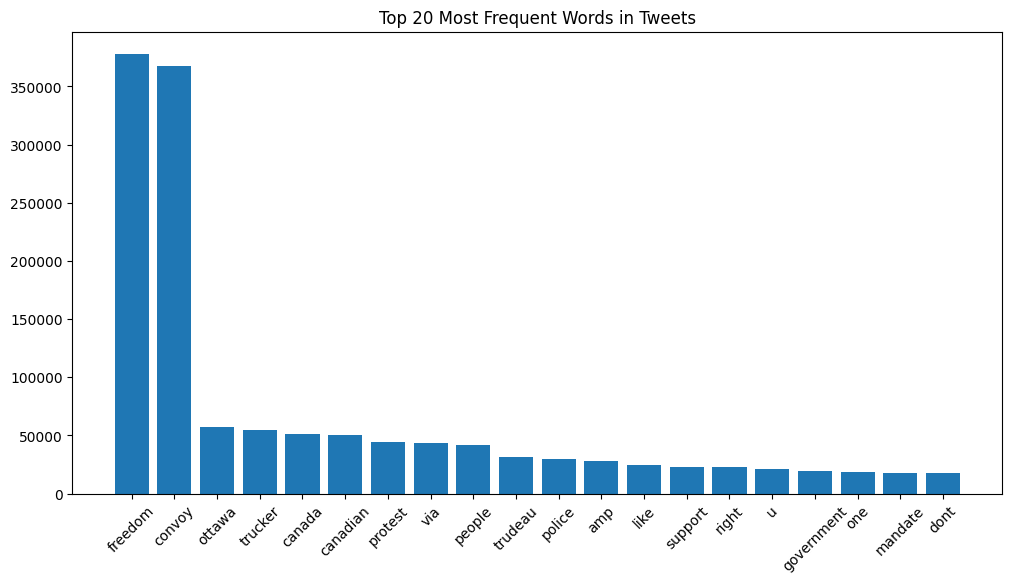

In [23]:
import matplotlib.pyplot as plt

words, counts = zip(*top_20)

plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words in Tweets')
plt.show()


After cleaning Freedom and convoy are the most occuring one.

## On Second thought....

I think the emojies, punctuation marks, numbers, hashtags should'nt have been removed. So changing the preprocessing little bit....

In [24]:
!pip install emoji --upgrade


In [25]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from emoji import demojize

# Download required resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english')) - {'no', 'not', 'nor', 'never'}  # preserve negation
lemmatizer = WordNetLemmatizer()

def preprocess_text_with_lemmatization(text):
    # 1. Convert any input to string
    text = str(text)

    # 2. Convert emojis to text (😊 → smiling_face)
    text = demojize(text, delimiters=(" ", " "))

    # 3. Convert to lowercase
    text = text.lower()

    # 4. Remove URLs
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)

    # 5. Remove HTML tags and entities
    text = re.sub(r"<.*?>|&\w+;", "", text)

    # 6. Remove unwanted special characters but keep @, #, and numbers
    text = re.sub(r"[^a-z0-9@#:\s!?']", "", text)

    # 7. Tokenize text
    words = text.split()

    # 8. Remove stopwords but preserve negations
    words = [word for word in words if word not in stop_words]

    # 9. Lemmatize words
    words = [lemmatizer.lemmatize(word) for word in words]

    # 10. Join cleaned words
    return " ".join(words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [26]:
sample = "Seriously it the best party I've ever seen!.🤩❤️🤠 #FreedomConvoy #FreedomConvoyAnniversary"
print(preprocess_text_with_lemmatization(sample))

seriously best party ever seen! starstruck redheart cowboyhatface #freedomconvoy #freedomconvoyanniversary


In [28]:
df['cleaned_Tweet'] = df_UTF['Tweet'].astype(str).apply(preprocess_text_with_lemmatization)

df[['cleaned_Tweet', 'Sentiment']].to_csv('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data_3.csv', index=False)

df = pd.read_csv('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data_3.csv')

#2 minutes

In [29]:
import pandas as pd
print("Texts before demojizing")
pd.read_csv('/content/drive/My Drive/dataset/Sentiment_Data/Sentiment_Data_utf8.csv').Tweet.iloc[70]


Texts before demojizing


"Seriously it the best party I've ever seen!.🤩❤️🤠\n\n#FreedomConvoy #FreedomConvoyAnniversary"

In [30]:
print("Texts after demojizing")
df.cleaned_Tweet.iloc[70]

Texts after demojizing


'seriously best party ever seen! starstruck redheart cowboyhatface #freedomconvoy #freedomconvoyanniversary'

In [31]:
df_cleaned_1 = pd.read_csv('/content/drive/MyDrive/dataset/Sentiment_Data/cleaned_sentiment_data.csv')
comparison_df = pd.DataFrame({
    'Original_cleaned_Tweet': df['cleaned_Tweet'],
    'New_cleaned_Tweet': df_cleaned_1['cleaned_Tweet']
})

# Display the first few rows side by side
comparison_df.head()

,Original_cleaned_Tweet,New_cleaned_Tweet
0,@angelicatoy happy anniversary!!!the day freed...,happy anniversarythe day freedumb died tune mc...
1,@mcfarlaneglenda happy anniversary!!!the day f...,happy anniversarythe day freedumb died tune mc...
2,@thevivafrei @justintrudeau happy anniversary!...,happy anniversarythe day freedumb died tune mc...
3,@nchartieret happy anniversary!!!the day freed...,happy anniversarythe day freedumb died tune mc...
4,@tabithapeters05 happy anniversary!!!the day f...,happy anniversarythe day freedumb died tune mc...


### Checking the word count again!

In [32]:
from collections import Counter
import re

# Combine all tweets into one string
all_text = " ".join(df['cleaned_Tweet'].astype(str))

# Tokenize words — simple way using regex to split on non-word characters
words = re.findall(r'\b\w+\b', all_text.lower())  # lowercase to treat 'The' and 'the' as same

# Count word frequencies
word_counts = Counter(words)
print("total number of words : ",sum(word_counts.values()),"\n\n")
# Get the 20 most common words
top_20 = word_counts.most_common(20)

# Print the results
for word, count in top_20:
    print(f"{word}: {count}")


total number of words :  6911895 


freedom: 385553
convoy: 370463
freedomconvoy: 94541
canada: 83360
ottawa: 65325
trucker: 52521
canadian: 50421
not: 50405
protest: 43910
via: 43825
people: 41349
s: 41267
trudeau: 37771
2022: 31900
police: 30335
youtube: 27835
like: 24569
no: 24174
support: 23065
right: 22163


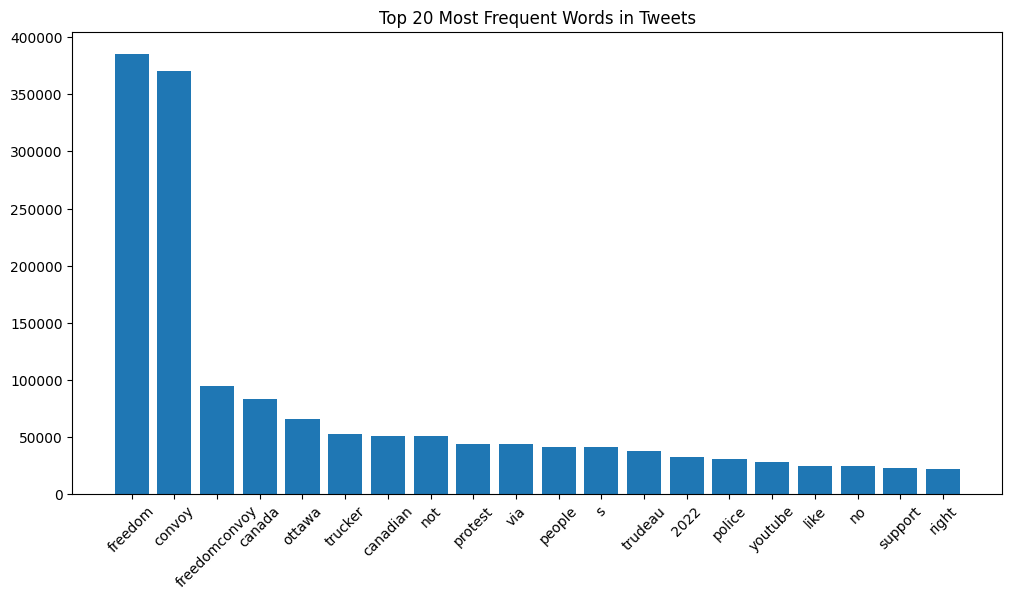

In [33]:
import matplotlib.pyplot as plt

words, counts = zip(*top_20)

plt.figure(figsize=(12,6))
plt.bar(words, counts)
plt.xticks(rotation=45)
plt.title('Top 20 Most Frequent Words in Tweets')
plt.show()


## Now I just wanted to see the words' frequency distribution across all classes

In [34]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_word_freq_for_class(df, sentiment_class, title):
    # Filter and clean text data for the given sentiment class
    text_data = " ".join(df[df['Sentiment'] == sentiment_class]['cleaned_Tweet'].dropna().astype(str))

    # Count word frequencies
    word_counts = Counter(text_data.split())

    # Get the top 20 most common words
    top_words = word_counts.most_common(20)

    # Print frequency distribution
    print(f"Top 20 words for class '{sentiment_class}':")
    for word, count in top_words:
        print(f"{word}: {count}")
    print()

    # Plotting
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color='skyblue')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


Top 20 words for class 'Mild_Pos':
freedom: 48462
convoy: 46141
#freedomconvoy: 11368
protest: 9293
ottawa: 8994
canada: 7544
trucker: 7419
canadian: 7356
not: 7052
via: 6605
police: 5437
trudeau: 5360
people: 5145
'freedom: 4098
no: 4094
convoy': 3821
like: 3308
emergency: 3297
u: 3114
@youtube: 3067



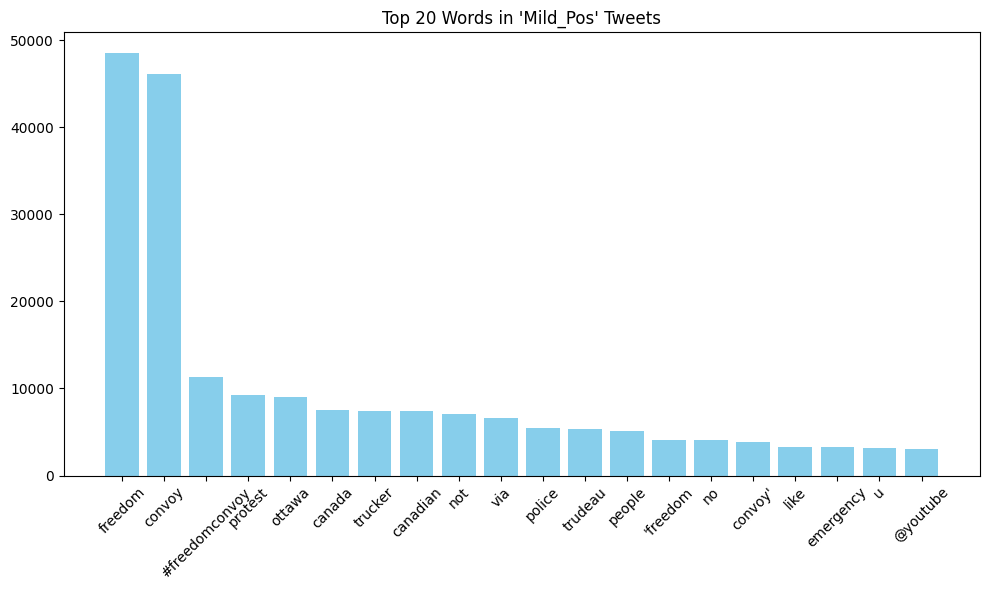

Top 20 words for class 'Strong_Pos':
freedom: 222456
convoy: 198916
canada: 37267
trucker: 29542
ottawa: 29017
via: 28177
canadian: 27479
2022: 24734
not: 23139
people: 19061
@youtube: 18657
#freedomconvoy: 17185
support: 16215
like: 15456
protest: 14725
trudeau: 14085
'freedom: 12476
police: 12159
convoy': 11481
u: 10576



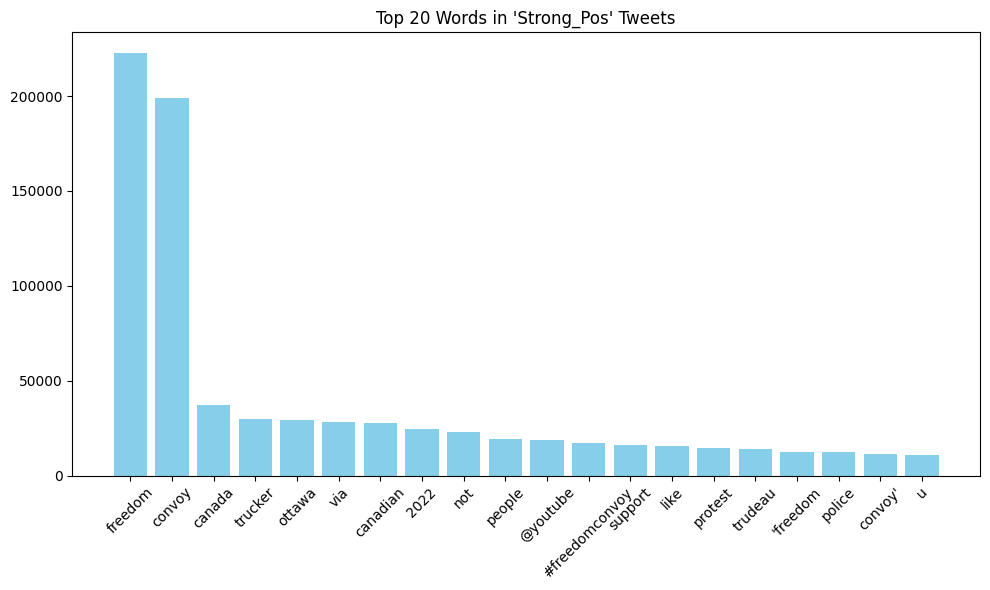

Top 20 words for class 'Neutral':
#freedomconvoy: 35851
convoy: 35663
freedom: 35075
canada: 10267
ottawa: 7083
not: 6306
trucker: 6137
canadian: 5821
protest: 5590
via: 4916
people: 4817
police: 4444
trudeau: 4395
#freedomconvoy2022: 4353
#canada: 3607
de: 3217
no: 3006
#cdnpoli: 2931
right: 2897
#freedom: 2830



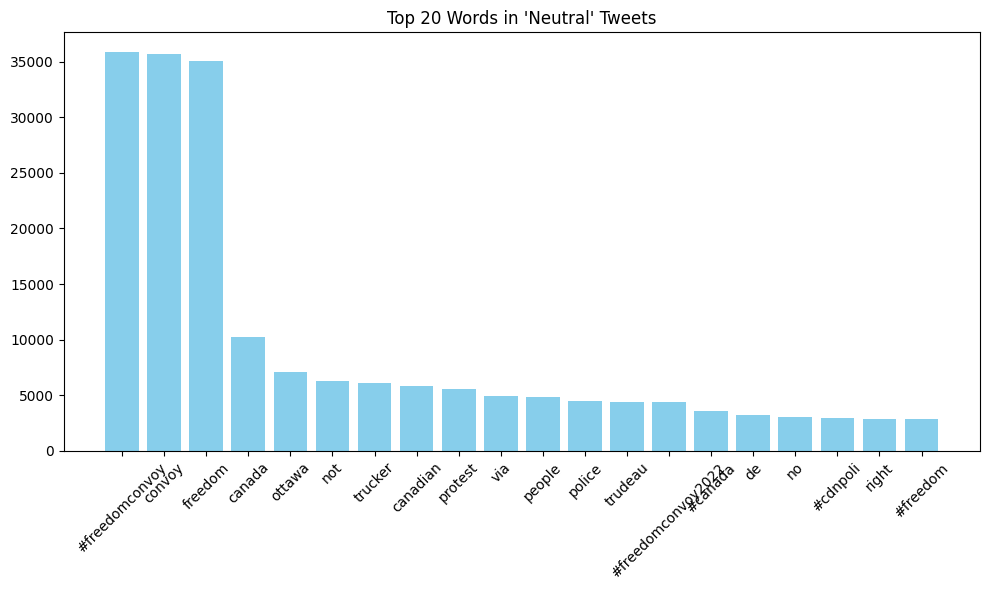

Top 20 words for class 'Strong_Neg':
freedom: 25687
convoy: 25377
#freedomconvoy: 14708
not: 8646
protest: 6226
people: 6009
no: 5867
canada: 5356
ottawa: 4771
canadian: 4635
trucker: 4343
police: 3864
trudeau: 3812
right: 2857
protester: 2712
u: 2478
one: 2460
government: 2361
get: 2207
hate: 2086



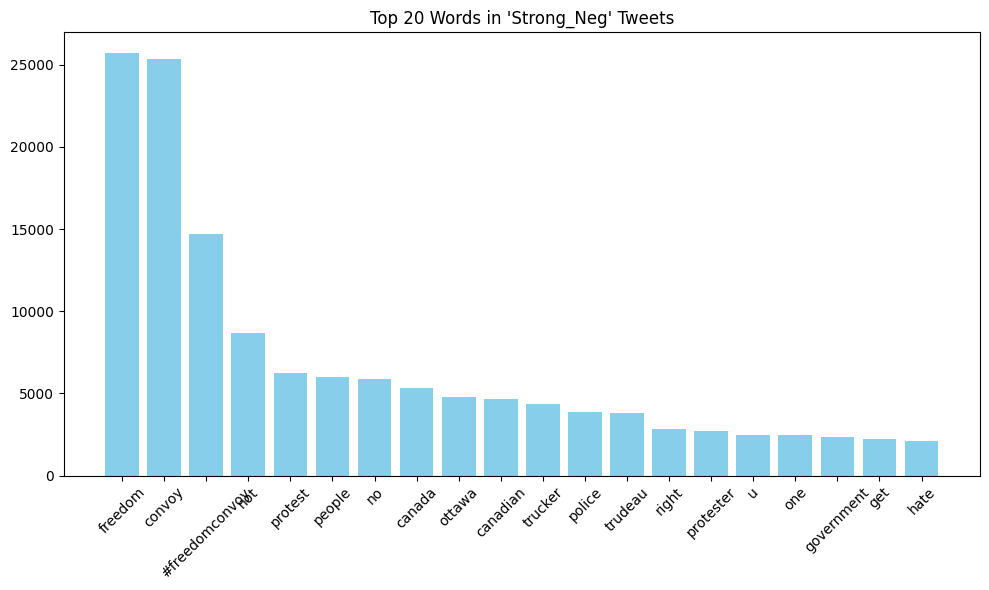

Top 20 words for class 'Mild_Neg':
freedom: 21503
convoy: 21429
#freedomconvoy: 10519
protest: 6351
not: 4793
ottawa: 4616
canada: 4339
canadian: 4044
trucker: 3947
police: 3515
people: 3300
no: 3149
trudeau: 2802
protester: 2476
via: 2401
mandate: 2074
emergency: 1973
u: 1779
right: 1708
government: 1705



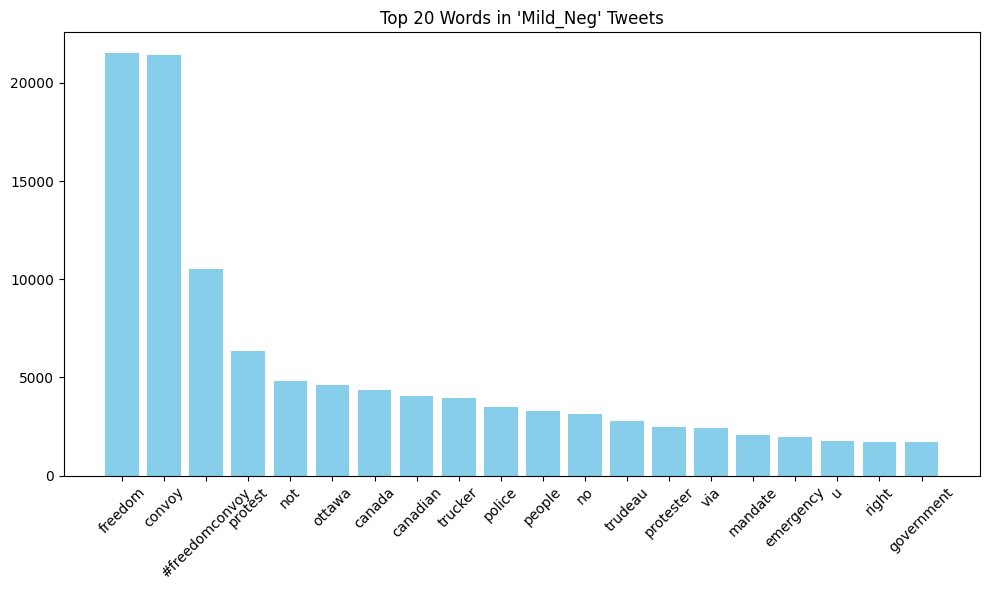

In [35]:
for sentiment in df['Sentiment'].unique():
    plot_word_freq_for_class(df, sentiment, f"Top 20 Words in '{sentiment}' Tweets")


###Checking and Dropiing columns with nan values

In [36]:
df.isna().sum()

,0
cleaned_Tweet,17
Sentiment,0


In [37]:
df = df.dropna()
df.isna().sum()

,0
cleaned_Tweet,0
Sentiment,0


##Sentiment mapping

In [38]:

#sentiment mapping
sentiment_mapping = {
    "Mild_Pos": "Positive",
    "Strong_Pos": "Positive",
    "Mild_Neg": "Negative",
    "Strong_Neg": "Negative",
    "Neutral": "Neutral"
}

# Map original sentiment labels to new ones
df["Sentiment"] = df["Sentiment"].map(sentiment_mapping)

# Show distribution of the new sentiment categories
print(df["Sentiment"].value_counts())

Sentiment
Positive    297704
Neutral      76999
Negative     76612
Name: count, dtype: int64


##Now let us see out the labels look like

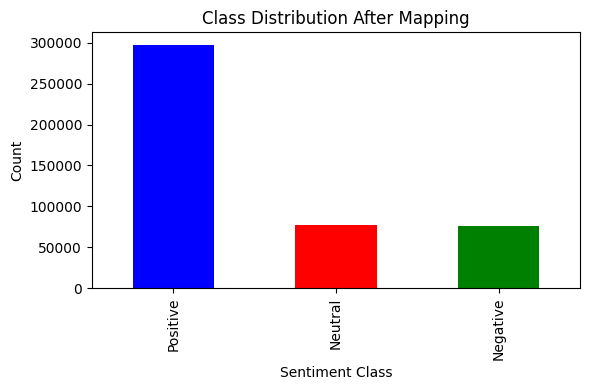

In [39]:
# Plot sentiment class distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
df["Sentiment"].value_counts().plot(kind="bar", color=["blue", "red", "green"])
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.title("Class Distribution After Mapping")
plt.tight_layout()
plt.show()


###Making things ready for

In [40]:
#counting the number of unique words in the cleaned_tweet column
df.columns
len(df.cleaned_Tweet.unique())

386785

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. Split into Train (80%) and Test (20%), stratified by sentiment
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df["Sentiment"]
)

# 2. Extract labels
y_train = train_df["Sentiment"].values
y_test = test_df["Sentiment"].values

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)




y_train shape: (361052,)
y_test shape: (90263,)


In [42]:


# Ensure tokenization is applied to both train and test sets
train_df["Tokens"] = train_df["cleaned_Tweet"].apply(lambda x: str(x).split())
test_df["Tokens"] = test_df["cleaned_Tweet"].apply(lambda x: str(x).split())


# Print a few tokenized samples
train_df[["cleaned_Tweet", "Tokens"]].head(2)


,cleaned_Tweet,Tokens
221228,what's millennial support freedom convoy? defi...,"[what's, millennial, support, freedom, convoy?..."
5380,@pmcculloughmd here's resume doubter,"[@pmcculloughmd, here's, resume, doubter]"


In [43]:
test_df.head(2)

,cleaned_Tweet,Sentiment,Tokens
299937,freedom convoy keep outsmarting liberal politi...,Positive,"[freedom, convoy, keep, outsmarting, liberal, ..."
189186,yall tweeting anti war song lyric ukraine not ...,Negative,"[yall, tweeting, anti, war, song, lyric, ukrai..."


In [44]:
# From training data
train_df.drop("cleaned_Tweet", axis=1, inplace=True)


# From test data

test_df.drop("cleaned_Tweet", axis=1, inplace=True)


In [45]:
train_df.head(2)

,Sentiment,Tokens
221228,Positive,"[what's, millennial, support, freedom, convoy?..."
5380,Negative,"[@pmcculloughmd, here's, resume, doubter]"


In [46]:
test_df.head(2)

,Sentiment,Tokens
299937,Positive,"[freedom, convoy, keep, outsmarting, liberal, ..."
189186,Negative,"[yall, tweeting, anti, war, song, lyric, ukrai..."


In [47]:
import matplotlib.pyplot as plt
import numpy as np

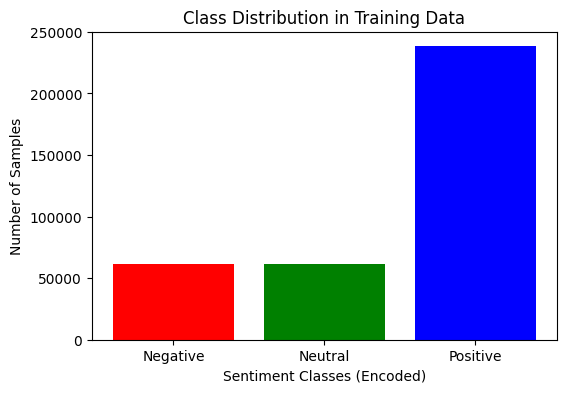

In [48]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Convert Sentiments to Numeric Labels first
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Step 2: Plot class distribution of original training labels
plt.figure(figsize=(6, 4))
plt.bar(np.unique(y_train_encoded), np.bincount(y_train_encoded), color=["red", "green", "blue"])
plt.xlabel("Sentiment Classes (Encoded)")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in Training Data")
plt.xticks(ticks=np.unique(y_train_encoded), labels=label_encoder.classes_)
plt.show()


##Poisitive label impact the class count with a huge imbalance. Let's apply weights during Tuning.

#Transfoermer

In [49]:
# !pip install gensim


In [ ]:
import gensim.downloader as api

w2v_model = api.load("word2vec-google-news-300")



In [51]:
import numpy as np

def get_embedding(tweet_tokens, model):
    embeddings = [model.wv.get_vector(word, norm=False) for word in tweet_tokens if word in model.wv]
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)

X_train_embed = np.array([get_embedding(tokens, w2v_model) for tokens in train_df["Tokens"]])
X_test_embed = np.array([get_embedding(tokens, w2v_model) for tokens in test_df["Tokens"]])


In [52]:
y_test.shape

(90263,)

In [53]:
X_test_embed.shape

(90263, 100)

#Imports and Positional Embedding Layer

In [54]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time


In [ ]:
sacfasdfdcb

#Positional Embedding Layer

In [57]:
class PositionEmbedding(layers.Layer):
    def __init__(self, sequence_length, embedding_dim):
        super(PositionEmbedding, self).__init__()
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embedding_dim
        )

    def call(self, inputs):
        # inputs shape: (batch_size, seq_len, embedding_dim)
        positions = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
        return self.position_embeddings(positions)


#Transformer Block Layer

In [58]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)  # Residual connection

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)  # Residual connection


#Build the Transformer Model

In [59]:
def build_model(seq_length, embed_dim, num_heads, ff_dim, num_classes):
    inputs = keras.Input(shape=(seq_length, embed_dim))  # (batch, seq_len, embed_dim)

    # Positional Embeddings
    pos_embedding = PositionEmbedding(seq_length, embed_dim)(inputs)
    x = inputs + pos_embedding  # Add position info

    # Transformer blocks (can stack multiple)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x, training=True)

    # Global average pooling over sequence length dimension
    x = layers.GlobalAveragePooling1D()(x)

    # Fully connected layers
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


#Prepare Data for the Model

In [60]:
# Your embedding dimension (same as Word2Vec vector size)
embed_dim = w2v_model.vector_size  # e.g., 100

# Since you averaged embeddings per tweet, seq_length=1 (single vector per tweet)
seq_length = 1

# Expand dims to add the sequence dimension
X_train_model = np.expand_dims(X_train_embed, axis=1)  # shape: (samples, 1, embed_dim)
X_test_model = np.expand_dims(X_test_embed, axis=1)

# Encode labels with LabelEncoder if not done
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode labels for multi-class classification
num_classes = len(np.unique(y_train_encoded))
y_train_cat = keras.utils.to_categorical(y_train_encoded, num_classes)
y_test_cat = keras.utils.to_categorical(y_test_encoded, num_classes)

print("X_train_model shape:", X_train_model.shape)
print("y_train_cat shape:", y_train_cat.shape)


X_train_model shape: (361052, 1, 100)
y_train_cat shape: (361052, 3)


#Compile and Train the Model with GPU

In [61]:
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {device}")

with tf.device(device):
    model = build_model(seq_length, embed_dim, num_heads=4, ff_dim=128, num_classes=num_classes)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

    start_time = time.time()
    history = model.fit(
        X_train_model, y_train_cat,
        validation_data=(X_test_model, y_test_cat),
        epochs=5,
        batch_size=64,
        verbose=2
    )
    end_time = time.time()
    print(f"Training time: {end_time - start_time:.2f} seconds")

model.summary()


Using device: /CPU:0
Epoch 1/5
5642/5642 - 307s - 54ms/step - accuracy: 0.7283 - loss: 0.6873 - val_accuracy: 0.7408 - val_loss: 0.6584
Epoch 2/5
5642/5642 - 302s - 54ms/step - accuracy: 0.7415 - loss: 0.6538 - val_accuracy: 0.7448 - val_loss: 0.6442
Epoch 3/5
5642/5642 - 282s - 50ms/step - accuracy: 0.7472 - loss: 0.6389 - val_accuracy: 0.7461 - val_loss: 0.6338
Epoch 4/5
5642/5642 - 290s - 51ms/step - accuracy: 0.7521 - loss: 0.6293 - val_accuracy: 0.7508 - val_loss: 0.6304
Epoch 5/5
5642/5642 - 316s - 56ms/step - accuracy: 0.7553 - loss: 0.6209 - val_accuracy: 0.7585 - val_loss: 0.6139
Training time: 1536.10 seconds


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1, 100)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (1, 100)          │        100 │ input_layer[0][0] │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 1, 100)    │          0 │ input_layer[0][0… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block   │ (None, 1, 100)    │    187,528 │ add[0][0]         │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_1 │ (None, 1, 100)    │    187,528 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      6,464 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3)         │        195 │ dropout_6[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,145,447 (4.37 MB)

 Trainable params: 381,815 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 763,632 (2.91 MB)

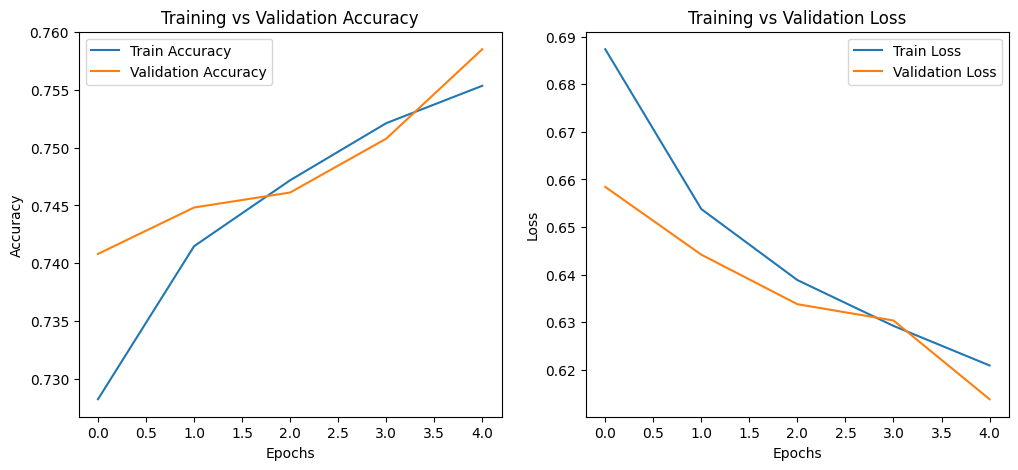

In [62]:


# Extract accuracy and loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc, label="Train Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label="Train Loss")
plt.plot(val_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.show()


In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score,
    f1_score,
    accuracy_score,
    roc_curve,
    auc,
    confusion_matrix
)
from sklearn.preprocessing import label_binarize

def compute_metrics(y_train_pred, y_train, y_test_pred, y_test, training_time, testing_time, epochs):
    """
    Compute evaluation metrics (AUC, F1, Accuracy) for multi-class classification.

    Parameters:
        y_train_pred: np.array, predicted probabilities for training set (one-hot or softmax output)
        y_train: np.array, true labels (one-hot encoded) for training set
        y_test_pred: np.array, predicted probabilities for test set (one-hot or softmax output)
        y_test: np.array, true labels (one-hot encoded) for test set
        training_time: float, time taken for training
        testing_time: float, time taken for testing
        epochs: int, number of epochs trained

    Returns:
        results_df: pd.DataFrame with training and testing metrics
    """

    # Convert one-hot encoded labels to class indices
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Compute AUC (One-vs-Rest multiclass)
    try:
        auc_train = roc_auc_score(y_train, y_train_pred, multi_class='ovr', average='macro')
    except ValueError:
        auc_train = 'N/A'

    try:
        auc_test = roc_auc_score(y_test, y_test_pred, multi_class='ovr', average='macro')
    except ValueError:
        auc_test = 'N/A'

    # Compute F1 Score per class
    f1_train = f1_score(y_train_labels, np.argmax(y_train_pred, axis=1), average=None)
    f1_test = f1_score(y_test_labels, np.argmax(y_test_pred, axis=1), average=None)

    # Compute Accuracy
    accuracy_train = accuracy_score(y_train_labels, np.argmax(y_train_pred, axis=1))
    accuracy_test = accuracy_score(y_test_labels, np.argmax(y_test_pred, axis=1))

    # Prepare results dictionaries
    results_train = {
        "Type": "Training",
        "Epochs": epochs,
        "Time Taken": training_time,
        "Accuracy": accuracy_train,
        "F1 Score (Negative)": f1_train[0] if len(f1_train) > 0 else 'N/A',
        "F1 Score (Neutral)": f1_train[1] if len(f1_train) > 1 else 'N/A',
        "F1 Score (Positive)": f1_train[2] if len(f1_train) > 2 else 'N/A',
        "AUC": auc_train
    }

    results_test = {
        "Type": "Testing",
        "Epochs": epochs,
        "Time Taken": testing_time,
        "Accuracy": accuracy_test,
        "F1 Score (Negative)": f1_test[0] if len(f1_test) > 0 else 'N/A',
        "F1 Score (Neutral)": f1_test[1] if len(f1_test) > 1 else 'N/A',
        "F1 Score (Positive)": f1_test[2] if len(f1_test) > 2 else 'N/A',
        "AUC": auc_test
    }

    # Store results in DataFrame
    results_df = pd.DataFrame([results_train, results_test])

    return results_df


def plot_results(y_train, y_train_pred, y_test, y_test_pred, class_labels):
    """
    Plot ROC curves and confusion matrices for multi-class classification.

    Parameters:
        y_train: np.array, true training labels (one-hot encoded)
        y_train_pred: np.array, predicted probabilities for training set
        y_test: np.array, true testing labels (one-hot encoded)
        y_test_pred: np.array, predicted probabilities for test set
        class_labels: list of str, class names in order

    Returns:
        None
    """

    # Convert one-hot encoded labels to class indices
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    y_train_pred_labels = np.argmax(y_train_pred, axis=1)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)

    # Binarize labels for ROC computation
    y_train_bin = label_binarize(y_train_labels, classes=np.arange(len(class_labels)))
    y_test_bin = label_binarize(y_test_labels, classes=np.arange(len(class_labels)))

    # Create subplots for ROC curves: train, test, comparison
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot ROC curves per class for train
    for i in range(len(class_labels)):
        fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_pred[:, i])
        roc_auc_train = auc(fpr_train, tpr_train)
        axes[0].plot(fpr_train, tpr_train, lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc_train:.2f})')

    axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title('Training Data ROC Curve')
    axes[0].legend(loc="lower right")

    # Plot ROC curves per class for test
    for i in range(len(class_labels)):
        fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_pred[:, i])
        roc_auc_test = auc(fpr_test, tpr_test)
        axes[1].plot(fpr_test, tpr_test, lw=2, label=f'Class {class_labels[i]} (AUC = {roc_auc_test:.2f})')

    axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title('Testing Data ROC Curve')
    axes[1].legend(loc="lower right")

    # Overall ROC curve (train vs test) averaged over classes
    # Compute micro-average ROC curve and ROC area for train
    fpr_train_micro, tpr_train_micro, _ = roc_curve(y_train_bin.ravel(), y_train_pred.ravel())
    roc_auc_train_micro = auc(fpr_train_micro, tpr_train_micro)

    # Compute micro-average ROC curve and ROC area for test
    fpr_test_micro, tpr_test_micro, _ = roc_curve(y_test_bin.ravel(), y_test_pred.ravel())
    roc_auc_test_micro = auc(fpr_test_micro, tpr_test_micro)

    axes[2].plot(fpr_train_micro, tpr_train_micro, lw=2, label=f'Train micro-average AUC = {roc_auc_train_micro:.2f}')
    axes[2].plot(fpr_test_micro, tpr_test_micro, lw=2, label=f'Test micro-average AUC = {roc_auc_test_micro:.2f}')
    axes[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].set_title('Training vs Testing ROC Curve (micro-average)')
    axes[2].legend(loc="lower right")

    plt.tight_layout()
    plt.show()

    # Compute confusion matrices
    cm_train = confusion_matrix(y_train_labels, y_train_pred_labels)
    cm_test = confusion_matrix(y_test_labels, y_test_pred_labels)

    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
    axes[0].set_title('Confusion Matrix - Training')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
    axes[1].set_title('Confusion Matrix - Testing')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()


In [64]:
# Step 1: Make predictions
y_train_pred = model.predict(X_train_model)
y_test_pred = model.predict(X_test_model)

# Step 2: Compute metrics and store results
training_time = end_time - start_time
testing_start_time = time.time()
_ = model.evaluate(X_test_model, y_test_cat, verbose=0)
testing_end_time = time.time()
testing_time = testing_end_time - testing_start_time

epochs = len(history.history['loss'])  # Number of epochs

results_df = compute_metrics(
    y_train_pred, y_train_cat,
    y_test_pred, y_test_cat,
    training_time, testing_time, epochs
)

# Step 3: Display results
print("\nEvaluation Results:")
print(results_df)


11283/11283 ━━━━━━━━━━━━━━━━━━━━ 59s 5ms/step
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step

Evaluation Results:
       Type  Epochs   Time Taken  Accuracy  F1 Score (Negative)  \
0  Training       5  1536.101543  0.762746             0.507744   
1   Testing       5    15.255811  0.758506             0.493921   

   F1 Score (Neutral)  F1 Score (Positive)       AUC  
0            0.505896             0.856537  0.846247  
1            0.498203             0.854437  0.840092  


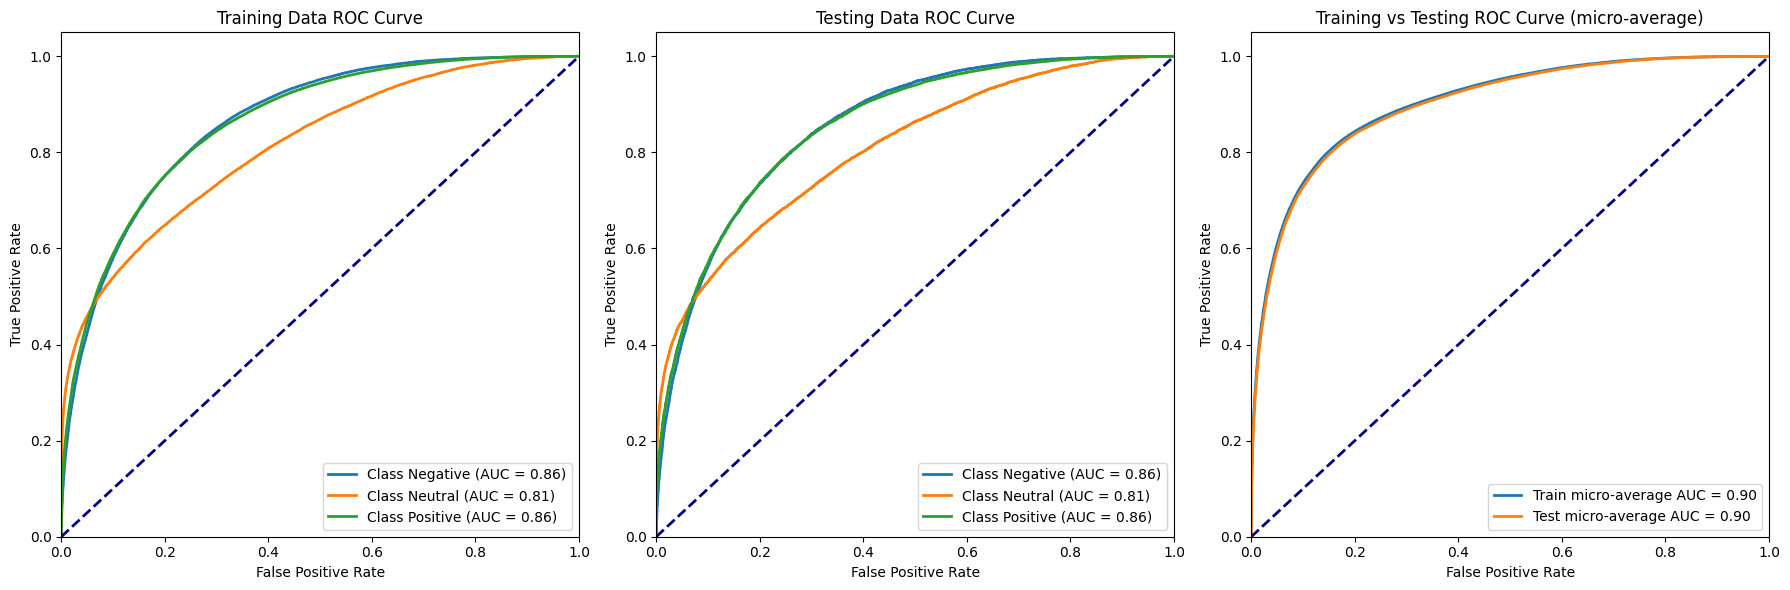

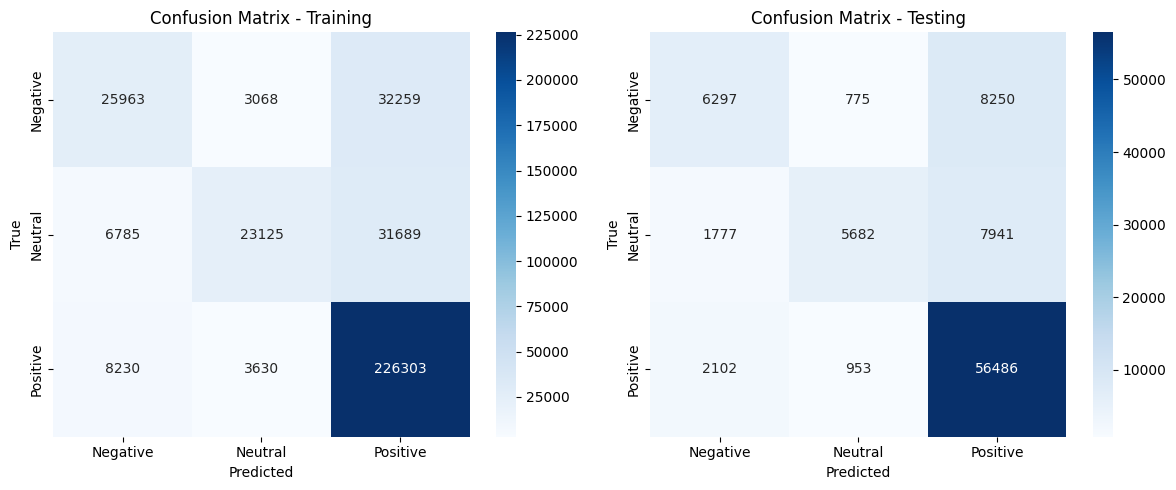

In [65]:

# Step 4: Plot ROC curves and confusion matrices
class_labels = ['Negative', 'Neutral', 'Positive']  # Update based on your task
plot_results(y_train_cat, y_train_pred, y_test_cat, y_test_pred, class_labels)


In [66]:
model.save('non_causal_tf.keras')
print("Model Saved")


Model Saved


#Tuning 1
###To improve the performance and generalization of the Transformer-based classification model, several enhancements were made:

**1.Increased Training Epochs**
- The original model trained for only 5 epochs, which is often insufficient for Transformer architectures. We increased this to 20 to allow the model to learn more complex patterns.

**2.EarlyStopping and ModelCheckpoint**
- EarlyStopping prevents overfitting by halting training when validation loss stops improving. ModelCheckpoint ensures the best model (based on validation accuracy) is saved during training.

**3.Stacked Transformer Blocks**
-  More transformer blocks (from 2 to 3) help the model capture deeper contextual relationships in the input embeddings.

**4.Learning Rate Scheduler**
- Instead of using a constant learning rate, an exponential decay schedule was added. This allows the model to take larger steps early in training and smaller steps later for fine-tuning.

**5.Label Smoothing**
→ A small amount of smoothing (0.1) was applied to the categorical cross-entropy loss. This regularizes the model and reduces overconfidence in predictions, improving generalization.

Dropout Regularization
- Dropout was increased to 0.2 in both the Transformer blocks and fully connected layers to reduce the risk of overfitting.

**6.Metrics Visualization**
- Accuracy and loss plots were added to visually monitor training progress and check for signs of underfitting or overfitting.

#Positional Embedding

In [55]:
class PositionEmbedding(layers.Layer):
    def __init__(self, sequence_length, embedding_dim):
        super(PositionEmbedding, self).__init__()
        self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=embedding_dim)

    def call(self, inputs):
        positions = tf.range(start=0, limit=tf.shape(inputs)[1], delta=1)
        return self.position_embeddings(positions)


#Transformer Block

In [56]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout_rate=0.2):
        super(TransformerBlock, self).__init__()
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn = keras.Sequential([
            layers.Dense(ff_dim, activation="relu"),
            layers.Dense(embed_dim),
        ])
        self.dropout1 = layers.Dropout(dropout_rate)
        self.dropout2 = layers.Dropout(dropout_rate)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.norm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.norm2(out1 + ffn_output)


#Build Model Function

In [68]:
def build_model(seq_length, embed_dim, num_heads, ff_dim, num_classes, dropout_rate=0.2, n_blocks=3):
    inputs = keras.Input(shape=(seq_length, embed_dim))
    pos_embedding = PositionEmbedding(seq_length, embed_dim)(inputs)
    x = inputs + pos_embedding

    for _ in range(n_blocks):
        x = TransformerBlock(embed_dim, num_heads, ff_dim, dropout_rate)(x, training=True)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs)


#Prepare Data

In [69]:


print("X_train_model shape:", X_train_model.shape)
print("y_train_cat shape:", y_train_cat.shape)


X_train_model shape: (361052, 1, 100)
y_train_cat shape: (361052, 3)


#Compile, Train

In [70]:


# Learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.9
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Callbacks
callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

with tf.device(device):
    model = build_model(
        seq_length=seq_length,
        embed_dim=embed_dim,
        num_heads=4,
        ff_dim=128,
        num_classes=num_classes,
        dropout_rate=0.2,
        n_blocks=3
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
        metrics=["accuracy"]
    )

    start_time = time.time()
    history = model.fit(
        X_train_model, y_train_cat,
        validation_data=(X_test_model, y_test_cat),
        epochs=20,
        batch_size=64,
        callbacks=callbacks,
        verbose=2
    )
    end_time = time.time()

    print(f"Training time: {end_time - start_time:.2f} seconds")

model.summary()


Epoch 1/20


5642/5642 - 431s - 76ms/step - accuracy: 0.7270 - loss: 0.7810 - val_accuracy: 0.7409 - val_loss: 0.7517
Epoch 2/20


5642/5642 - 445s - 79ms/step - accuracy: 0.7438 - loss: 0.7493 - val_accuracy: 0.7498 - val_loss: 0.7364
Epoch 3/20


5642/5642 - 417s - 74ms/step - accuracy: 0.7516 - loss: 0.7344 - val_accuracy: 0.7557 - val_loss: 0.7284
Epoch 4/20


5642/5642 - 409s - 72ms/step - accuracy: 0.7568 - loss: 0.7257 - val_accuracy: 0.7577 - val_loss: 0.7187
Epoch 5/20


5642/5642 - 443s - 78ms/step - accuracy: 0.7597 - loss: 0.7209 - val_accuracy: 0.7606 - val_loss: 0.7154
Epoch 6/20


5642/5642 - 439s - 78ms/step - accuracy: 0.7617 - loss: 0.7175 - val_accuracy: 0.7620 - val_loss: 0.7134
Epoch 7/20


5642/5642 - 446s - 79ms/step - accuracy: 0.7630 - loss: 0.7153 - val_accuracy: 0.7621 - val_loss: 0.7125
Epoch 8/20


5642/5642 - 441s - 78ms/step - accuracy: 0.7639 - loss: 0.7142 - val_accuracy: 0.7628 - val_loss: 0.7117
Epoch 9/20


5642/5642 - 448s - 79ms/step - accuracy: 0.7637 - loss: 0.7134 - val_accuracy: 0.7632 - val_loss: 0.7117
Epoch 10/20
5642/5642 - 415s - 74ms/step - accuracy: 0.7637 - loss: 0.7134 - val_accuracy: 0.7632 - val_loss: 0.7115
Epoch 11/20
5642/5642 - 437s - 77ms/step - accuracy: 0.7640 - loss: 0.7135 - val_accuracy: 0.7630 - val_loss: 0.7113
Epoch 12/20


5642/5642 - 416s - 74ms/step - accuracy: 0.7648 - loss: 0.7128 - val_accuracy: 0.7633 - val_loss: 0.7113
Epoch 13/20
5642/5642 - 442s - 78ms/step - accuracy: 0.7644 - loss: 0.7130 - val_accuracy: 0.7632 - val_loss: 0.7113
Epoch 14/20
5642/5642 - 436s - 77ms/step - accuracy: 0.7643 - loss: 0.7129 - val_accuracy: 0.7631 - val_loss: 0.7113
Epoch 15/20
5642/5642 - 416s - 74ms/step - accuracy: 0.7643 - loss: 0.7130 - val_accuracy: 0.7632 - val_loss: 0.7113
Epoch 16/20
5642/5642 - 437s - 78ms/step - accuracy: 0.7642 - loss: 0.7130 - val_accuracy: 0.7631 - val_loss: 0.7113
Epoch 17/20
5642/5642 - 443s - 79ms/step - accuracy: 0.7647 - loss: 0.7127 - val_accuracy: 0.7631 - val_loss: 0.7113
Epoch 18/20
5642/5642 - 440s - 78ms/step - accuracy: 0.7641 - loss: 0.7131 - val_accuracy: 0.7631 - val_loss: 0.7113
Epoch 19/20
5642/5642 - 446s - 79ms/step - accuracy: 0.7644 - loss: 0.7129 - val_accuracy: 0.7631 - val_loss: 0.7113
Epoch 20/20
5642/5642 - 438s - 78ms/step - accuracy: 0.7643 - loss: 0.7129 -

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1, 100)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding… │ (1, 100)          │        100 │ input_layer_3[0]… │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 1, 100)    │          0 │ input_layer_3[0]… │
│                     │                   │            │ position_embeddi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_2 │ (None, 1, 100)    │    187,528 │ add_1[0][0]       │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_3 │ (None, 1, 100)    │    187,528 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_block_4 │ (None, 1, 100)    │    187,528 │ transformer_bloc… │
│ (TransformerBlock)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 100)       │          0 │ transformer_bloc… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 64)        │      6,464 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 64)        │          0 │ dense_12[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 3)         │        195 │ dropout_16[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,708,030 (6.52 MB)

 Trainable params: 569,343 (2.17 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,138,687 (4.34 MB)

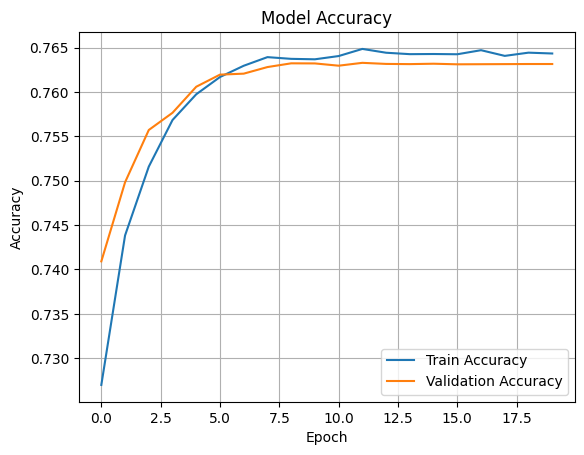

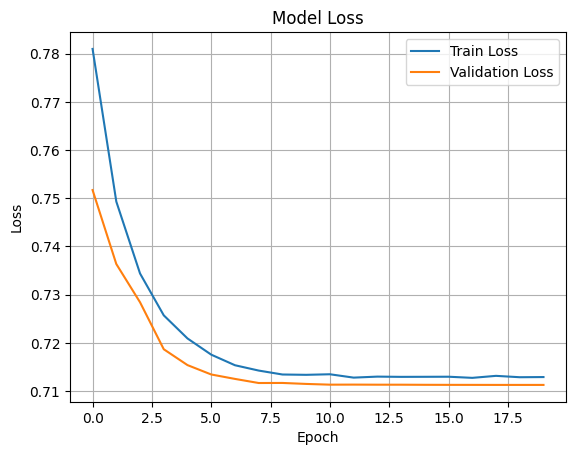

In [71]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

print("\n\n")
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()



In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_auc_score, f1_score, accuracy_score,
    roc_curve, auc, confusion_matrix
)
from sklearn.preprocessing import label_binarize

def compute_metrics(y_train_pred, y_train, y_test_pred, y_test, training_time, testing_time, epochs, class_labels):
    # Convert one-hot encoded labels to class indices
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)

    # Compute AUC (multi-class ROC AUC) with one-vs-rest approach
    try:
        auc_train = roc_auc_score(y_train, y_train_pred, multi_class='ovr', average='macro')
    except ValueError:
        auc_train = 'N/A'

    try:
        auc_test = roc_auc_score(y_test, y_test_pred, multi_class='ovr', average='macro')
    except ValueError:
        auc_test = 'N/A'

    # Compute F1 Score per class and average
    f1_train = f1_score(y_train_labels, np.argmax(y_train_pred, axis=1), average=None)
    f1_test = f1_score(y_test_labels, np.argmax(y_test_pred, axis=1), average=None)
    f1_train_avg = f1_score(y_train_labels, np.argmax(y_train_pred, axis=1), average='macro')
    f1_test_avg = f1_score(y_test_labels, np.argmax(y_test_pred, axis=1), average='macro')

    # Compute Accuracy
    accuracy_train = accuracy_score(y_train_labels, np.argmax(y_train_pred, axis=1))
    accuracy_test = accuracy_score(y_test_labels, np.argmax(y_test_pred, axis=1))

    # Prepare results dictionaries for training and testing
    def prepare_f1_dict(f1_scores):
        return {f"F1 Score ({cls})": f1_scores[i] if i < len(f1_scores) else 'N/A'
                for i, cls in enumerate(class_labels)}

    results_train = {
        "Type": "Training",
        "Epochs": epochs,
        "Time Taken (s)": training_time,
        "Accuracy": accuracy_train,
        "F1 Score (Average)": f1_train_avg,
        "AUC": auc_train
    }
    results_train.update(prepare_f1_dict(f1_train))

    results_test = {
        "Type": "Testing",
        "Epochs": epochs,
        "Time Taken (s)": testing_time,
        "Accuracy": accuracy_test,
        "F1 Score (Average)": f1_test_avg,
        "AUC": auc_test
    }
    results_test.update(prepare_f1_dict(f1_test))

    results_df = pd.DataFrame([results_train, results_test])
    return results_df

def plot_results(y_train, y_train_pred, y_test, y_test_pred, class_labels):
    y_train_labels = np.argmax(y_train, axis=1)
    y_test_labels = np.argmax(y_test, axis=1)
    y_train_pred_labels = np.argmax(y_train_pred, axis=1)
    y_test_pred_labels = np.argmax(y_test_pred, axis=1)

    # Binarize labels for ROC curve
    y_train_bin = label_binarize(y_train_labels, classes=np.arange(len(class_labels)))
    y_test_bin = label_binarize(y_test_labels, classes=np.arange(len(class_labels)))

    # Create subplots for ROC curves (one subplot per class)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Plot ROC curves per class for training data
    for i in range(len(class_labels)):
        fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_pred[:, i])
        roc_auc_train = auc(fpr_train, tpr_train)
        axes[0].plot(fpr_train, tpr_train, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc_train:.2f})')
    axes[0].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[0].set_title('Training Data ROC Curve')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].legend(loc='lower right')
    axes[0].set_xlim([0.0, 1.0])
    axes[0].set_ylim([0.0, 1.05])

    # Plot ROC curves per class for testing data
    for i in range(len(class_labels)):
        fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_pred[:, i])
        roc_auc_test = auc(fpr_test, tpr_test)
        axes[1].plot(fpr_test, tpr_test, lw=2, label=f'{class_labels[i]} (AUC = {roc_auc_test:.2f})')
    axes[1].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[1].set_title('Testing Data ROC Curve')
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].legend(loc='lower right')
    axes[1].set_xlim([0.0, 1.0])
    axes[1].set_ylim([0.0, 1.05])

    # Plot combined ROC curves (train vs test) for each class on the last subplot
    for i in range(len(class_labels)):
        fpr_train, tpr_train, _ = roc_curve(y_train_bin[:, i], y_train_pred[:, i])
        fpr_test, tpr_test, _ = roc_curve(y_test_bin[:, i], y_test_pred[:, i])
        roc_auc_train = auc(fpr_train, tpr_train)
        roc_auc_test = auc(fpr_test, tpr_test)
        axes[2].plot(fpr_train, tpr_train, lw=2, linestyle='-', label=f'Train {class_labels[i]} (AUC = {roc_auc_train:.2f})')
        axes[2].plot(fpr_test, tpr_test, lw=2, linestyle='--', label=f'Test {class_labels[i]} (AUC = {roc_auc_test:.2f})')
    axes[2].plot([0, 1], [0, 1], 'k--', lw=2)
    axes[2].set_title('Training vs Testing ROC Curves')
    axes[2].set_xlabel('False Positive Rate')
    axes[2].set_ylabel('True Positive Rate')
    axes[2].legend(loc='lower right')
    axes[2].set_xlim([0.0, 1.0])
    axes[2].set_ylim([0.0, 1.05])

    plt.tight_layout()
    plt.show()

    # Confusion matrices
    cm_train = confusion_matrix(y_train_labels, y_train_pred_labels)
    cm_test = confusion_matrix(y_test_labels, y_test_pred_labels)

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[0])
    axes[0].set_title('Confusion Matrix - Training')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels, ax=axes[1])
    axes[1].set_title('Confusion Matrix - Testing')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')

    plt.tight_layout()
    plt.show()


In [74]:
# Step 1: Make predictions
y_train_pred = model.predict(X_train_model)
y_test_pred = model.predict(X_test_model)

# Step 2: Compute metrics and store results
training_time = end_time - start_time
testing_start_time = time.time()
_ = model.evaluate(X_test_model, y_test_cat, verbose=0)
testing_end_time = time.time()
testing_time = testing_end_time - testing_start_time

epochs = len(history.history['loss'])  # Number of epochs




11283/11283 ━━━━━━━━━━━━━━━━━━━━ 97s 9ms/step
2821/2821 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step


In [77]:
class_labels = ['Negative', 'Neutral', 'Positive']
results_df = compute_metrics(
    y_train_pred, y_train_cat,
    y_test_pred, y_test_cat,
    training_time, testing_time, epochs,class_labels
)

# Step 3: Display results
print("\nEvaluation Results:")
print(results_df)


Evaluation Results:
       Type  Epochs  Time Taken (s)  Accuracy  F1 Score (Average)       AUC  \
0  Training      20     8685.522436  0.769330            0.643610  0.851136   
1   Testing      20       41.083572  0.763148            0.633807  0.845884   

   F1 Score (Negative)  F1 Score (Neutral)  F1 Score (Positive)  
0             0.539921            0.529707             0.861202  
1             0.523475            0.520391             0.857555  


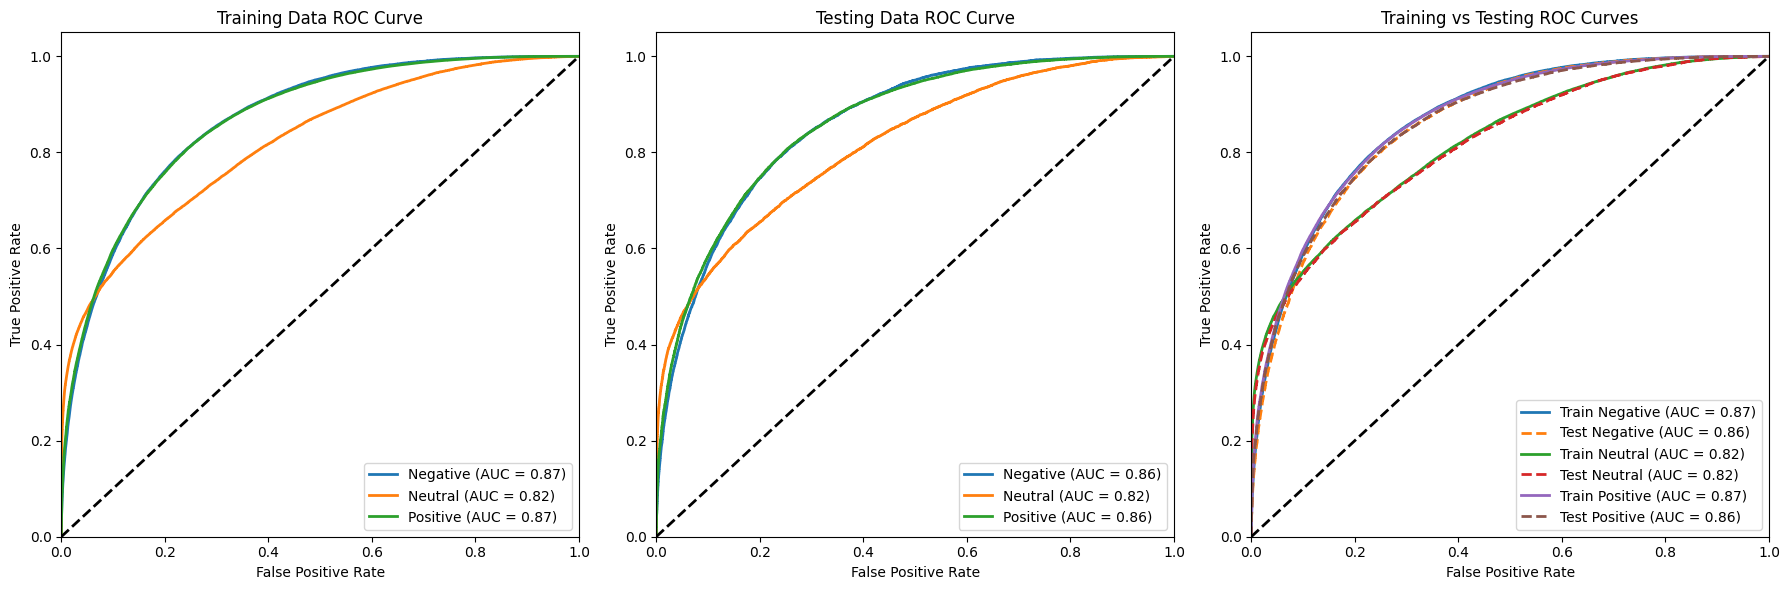

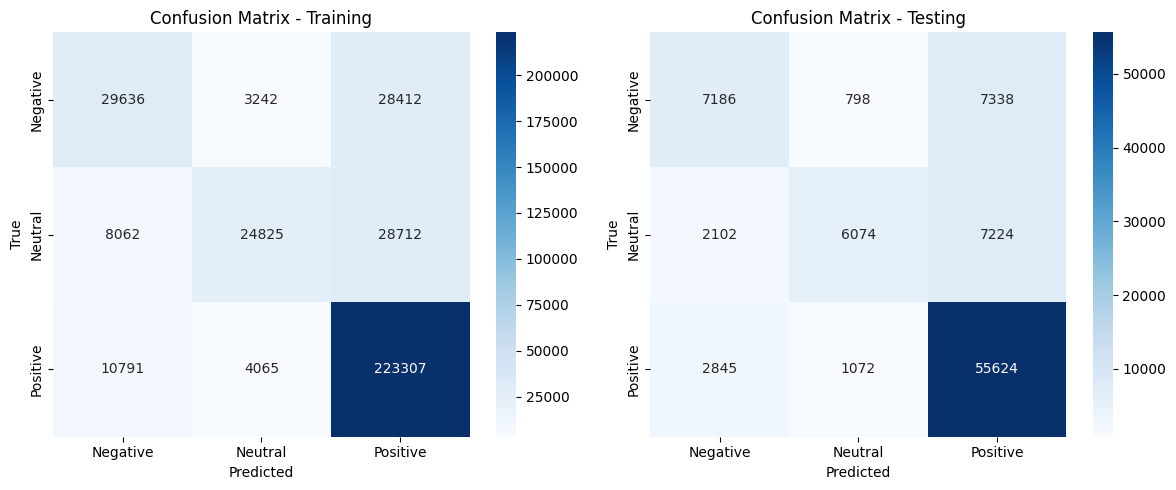

In [78]:

# Step 4: Plot ROC curves and confusion matrices
class_labels = ['Negative', 'Neutral', 'Positive']  # Update based on your task
plot_results(y_train_cat, y_train_pred, y_test_cat, y_test_pred, class_labels)


In [79]:
model.save('non_causal_tf_tuning_1.keras')
print("Model Saved")


Model Saved
